In [205]:
from skimage.io import imread
import numpy as np
from scipy.fftpack import dct, idct
from scipy.signal import convolve2d
from matplotlib import pyplot as plt
import time
import math
from google.colab import drive

In [206]:
drive.mount('/content/drive')
rootfolder = '/content/drive/MyDrive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Initialization and creating of noise
----------------------------------------

Definition of dct2 and idct2 (they are not builtin functions)

In [207]:
def dct2(s):
    return dct(dct(s.T, norm='ortho').T, norm='ortho')


def idct2(x):
    return idct(idct(x.T, norm='ortho').T, norm='ortho')

Useful function for plot the 2D DCT dictionary

In [208]:
def get_dictionary_img(D):
    M = D.shape[0]
    p = int(round(np.sqrt(M)))
    bound = 2
    img = np.ones((p*p+bound*(p-1), p*p+bound*(p-1)))
    for i in range(M):
        m = np.mod(i, p)
        n = int((i-m)/p)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Load the image and rescale it in $[0,1]$

In [209]:
#img = imread(f'{rootfolder}/data/couple.png') / 255
img = imread(f'{rootfolder}/data/cameraman.png') / 255
# img = np.roll(img, 1, axis=0)
# img = np.roll(img, 1, axis=1)
# img = imread(f'{rootfolder}/data/barbara.png') / 255
# img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Corrupt the image with white gaussian noise

In [210]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise

Compute the psnr of the noisy input

In [211]:
mse_noisy = ((img-noisy_img)**2).mean()
psnr_noisy= 10*math.log10(1/mse_noisy)

Text(0.5, 1.0, 'Noisy image, PSNR = 22.12')

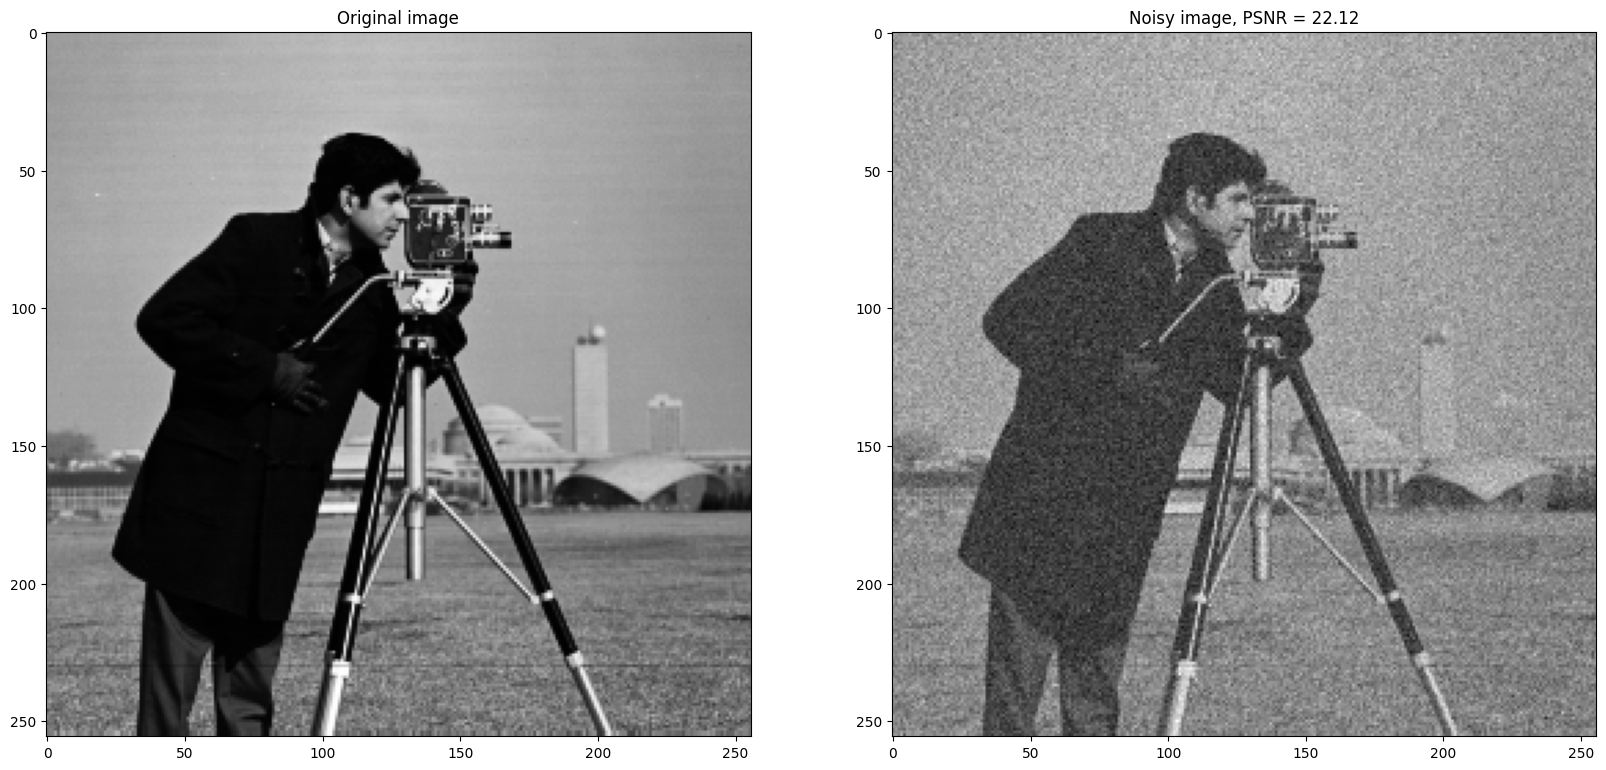

In [212]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


DCT denoising by Hard Thresholding
----------------------------------
Generate the DCT basis

In [213]:
D = np.zeros((M, M))
cnt = 0
for i in range(p):
    for j in range(p):
        a = np.zeros((p, p))
        a[i, j] = 1
        D[:, cnt] = idct2(a).flatten().T
        cnt = cnt + 1


Denoising: set parameters and initialize the variables

In [214]:
# initialize the estimated image
img_hat_HT = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

# set the threshold for the Hard Thresholding
tau = 3 * sigma_noise 
# Donoho says: 
#tau = sigma_noise * np.sqrt(2*np.log(p**2))

# define the step (=p for non overlapping paches)
STEP = 1

Perform the denoising pathwise

In [215]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p,j:j+p].flatten()

        # compute the representation w.r.t. the 2D DCT dictionary
        x = D.T@s

        # perform the hard thresholding (do not perform HT on the DC!)
        x_HT = x.copy()
        x_HT[np.abs(x_HT)<=tau] = 0
        x_HT[0]=x[0] 

        # perform the reconstruction
        s_hat = D@x_HT

        # compute the weight for the reconstructed patch
        nnz_patch = np.count_nonzero(x_HT)
        if nnz_patch==0:
         nnz_patch = 1
        w = 1/nnz_patch
        # UNIFORM WEIGHTS:
        #w=1

        # put the compressed patch into the compressed image using the computed weight
        # UPDATE img_hat
        img_hat_HT[i:i+p,j:j+p] += np.reshape(s_hat, (p,p)) * w

        # store the weight of the current patch in the weight matrix
        # UPDATE weights
        # serve fare += perché nel caso di step 1 ho anche sovrapposizione e devo tenere conto di tutti i filtri lì intorno
        # nel caso di STEP = p non ho sovrapposizione quindi non ce n'è bisogno
        weights[i:i+p,j:j+p] += w

# Normalize the estimated image with the computed weights
img_hat_HT = img_hat_HT / weights

Wiener Filtering
----------------
Initialize the variables

In [216]:
img_hat_wiener = np.zeros_like(img)
weights = np.zeros_like(img)

Perform the denoising patchwise

In [217]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p,j:j+p].flatten()

        # compute the representation w.r.t. the 2D DCT dictionary
        x = D.T@s

        # extrach the patch from the image estimated by HT with the top left corner at pixel (ii, jj)
        s_hat_HT = img_hat_HT[i:i+p,j:j+p].flatten()
        # compute the representation w.r.t. the 2D DCT dictionary
        x_hat_HT = D.T@s_hat_HT

        # perform the wiener filtering (do not filter the DC!)
        x_wiener = (x_hat_HT)**2/((x_hat_HT)**2 + sigma_noise**2) * x
        x_wiener[0] = x[0]

        # perform the reconstruction
        s_hat_wiener = D @ x_wiener

        # use uniform weights to aggregate the multiple estimates
        w = 1

        # put the compressed patch into the compressed image using the computed weight
        # UPDATE img_hat_wiener
        img_hat_wiener[i:i+p,j:j+p] += np.reshape(s_hat_wiener, (p,p)) * w

        # store the weight of the current patch in the weight matrix
        # UPDATE weights
        weights[i:i+p,j:j+p] += w

# Normalize the estimated image with the computed weights
img_hat_wiener = img_hat_wiener / weights

Compute the psnr of the two estimates

Text(0.5, 1.0, 'Wiener Estimate, PSNR = 29.43')

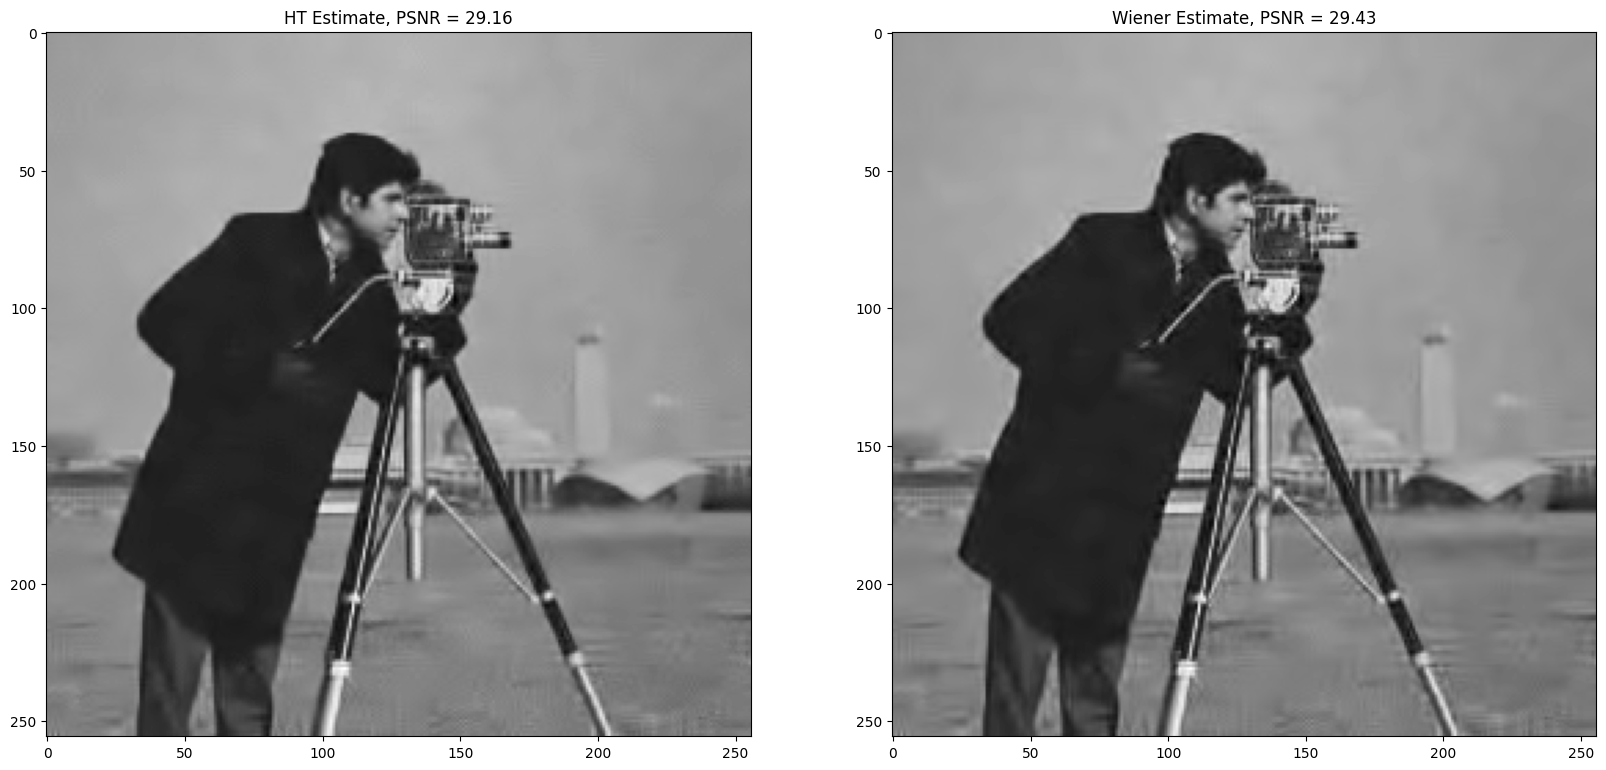

In [218]:
psnr_hat_HT = 10*np.log10(1/((img_hat_HT-img)**2).mean(axis=None))
psnr_hat_wiener = 10*math.log10(1/((img_hat_wiener-img)**2).mean(axis=None))

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img_hat_HT, cmap='gray')
ax[0].set_title(f'HT Estimate, PSNR = {psnr_hat_HT:.2f}')

ax[1].imshow(img_hat_wiener, cmap='gray')
ax[1].set_title(f'Wiener Estimate, PSNR = {psnr_hat_wiener:.2f}')
